## 2.ipnbとの差分
- モデルの改良(ハイパーパラメータチューニング)

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import os
for dirname, _, filenames in os.walk('../data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/data_description.txt
../data/sample_submit.csv
../data/test.csv
../data/train.csv
../data/.ipynb_checkpoints\sample_submit-checkpoint.csv
../data/.ipynb_checkpoints\test-checkpoint.csv
../data/.ipynb_checkpoints\train-checkpoint.csv


## 特徴量の生成

In [17]:
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')
sample_sub = pd.read_csv('../data/sample_submit.csv')

train_Id = train_df['index']
test_Id = test_df['index']

train_df.drop(columns=['index'])
test_df.drop(columns=['index'])

# set type label
train_df['type'] = 'train'
test_df['type'] = 'test'

combined_df = pd.concat((train_df, test_df))

## ラベルエンコーディング
参考：https://zenn.dev/yuto_mo/articles/131c49be5aee53　　、　https://www.salesanalytics.co.jp/datascience/datascience233/

In [18]:
# labelエンコーディングの適応（Lot ShapeとLand ContourはOrdinalエンコーディングかも）
cols = ('Lot Shape', 'Land Contour', 'Lot Config', 'Neighborhood', 'House Style', 'Roof Style', 'Central Air', 'Paved Drive', 'Sale Type', 'Sale Condition')
for c in cols:
    le = LabelEncoder()
    combined_df[c] = le.fit_transform(combined_df[c])

# Ordinalエンコーディング
exterior_order=['Ex', 'Gd', 'TA']
heating_QC_order=['Ex', 'Gd', 'TA']
kitchen_QC_order=['Ex', 'Gd', 'TA', 'Fa']
combined_df['Exter Qual'] = pd.Categorical(combined_df['Exter Qual'], categories=exterior_order, ordered=True).codes
combined_df['Heating QC'] = pd.Categorical(combined_df['Heating QC'], categories=heating_QC_order, ordered=True).codes
combined_df['Kitchen Qual'] = pd.Categorical(combined_df['Kitchen Qual'], categories=kitchen_QC_order, ordered=True).codes

# One-Hotエンコーディングの適用（ElectricalはOrdinalエンコーディングかも）
cols = ['MS Zoning', 'Bldg Type', 'Exterior 1st', 'Exterior 2nd', 'Foundation', 'Electrical']
combined_df = pd.get_dummies(combined_df, columns=cols)


### モデルの改良(特徴量の追加)

In [11]:
combined_df['YrBltAndRemod']=combined_df['Year Built']+combined_df['Year Remod/Add']

combined_df['TotalSF'] = combined_df['1st Flr SF'] + combined_df['2nd Flr SF']

combined_df['Total_sqr_footage'] = (combined_df['BsmtFin SF 1'] + 
                                 combined_df['1st Flr SF'] + combined_df['2nd Flr SF'])

combined_df['Total_Bathrooms'] = (combined_df['Full Bath'] + (0.5 * combined_df['Half Bath']) +
                               combined_df['Bsmt Full Bath'])

combined_df['Total_porch_sf'] = (combined_df['Open Porch SF'] + combined_df['Wood Deck SF'])

### EDA

In [12]:
# trainとtestに分けなおす
train_df = combined_df[combined_df['type'] == 'train']
test_df = combined_df[combined_df['type'] == 'test'].drop(columns=['SalePrice'])

# 学習に不要な特徴量を削除
train_df = train_df.drop(columns=['type'])
test_df = test_df.drop(columns=['type'])

# 評価データ作成
X_train = train_df.drop("SalePrice", axis=1)
y_train = train_df["SalePrice"]
X_test  = test_df

print(X_train.shape, y_train.shape, X_test.shape)

(3000, 77) (3000,) (2000, 77)


#### LightGBM（Optunaによるハイパーパラメータチューニング）

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2881
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 57
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 150495.585000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

,number,value,params_baggin_fraction,params_num_leaves
0,0,28160.015490,0.721770,393
1,1,28160.015490,0.444504,103
2,2,28160.015490,0.595187,114
3,3,28160.015490,0.690908,802
4,4,28160.015490,0.193216,506
5,5,28160.015490,0.725236,488
6,6,28148.444463,0.462673,44
7,7,28160.015490,0.276746,589
8,8,28229.064936,0.431831,32
9,9,28160.015490,0.508920,160


NameError: name 'test_preds' is not defined

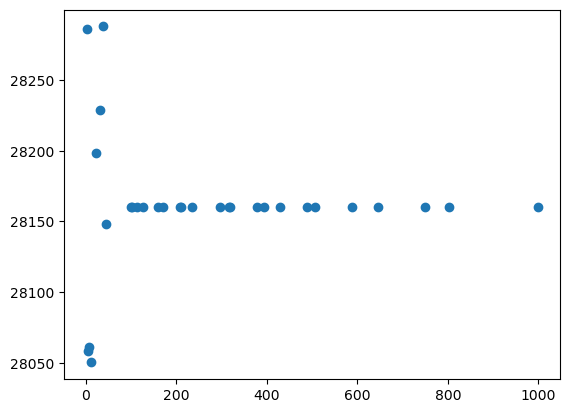

In [7]:
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import optuna

# optunaのログがうるさい場合は以下のコードで表示しなくなります
import warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)


# パラメータの候補を与えて最大/最小化したい目的値を返す関数を定義します
# 今回は3foldのクロスバリデーションの平均精度を目的値とします
def objective(trial):    
    lgb_params = {
        "objective":"regression","metric": "rmse",
        # パラメータの候補を整数の範囲で与えます. num_leavesは2~2^10の範囲で探索します.
        "num_leaves": trial.suggest_int('num_leaves', 2, 2**10),
        # パラメータの候補を小数の範囲で与えます. 
        "bagging_fraction": trial.suggest_uniform('baggin_fraction', 0.1, 0.9),
    }
    cv = KFold(n_splits=3, random_state=42, shuffle=True)
    rmse_results = []
    # 検証データの予測値を保存するための配列。
    test_preds = np.zeros(len(X_test))

    for trn_index, val_index in cv.split(X_train, y_train):
        X_trn, X_val = X_train.loc[trn_index], X_train.loc[val_index]
        y_trn, y_val = y_train[trn_index], y_train[val_index]

        train_lgb = lgb.Dataset(X_trn, y_trn)
        validation_lgb = lgb.Dataset(X_val, y_val)
        model = lgb.train(
            lgb_params, train_lgb, 
            num_boost_round=1000, valid_sets=[train_lgb, validation_lgb], 
            callbacks=[lgb.log_evaluation(period=10),lgb.early_stopping(100)]
            )
        pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, pred))
        print("RMSE:", rmse)
        rmse_results.append(rmse)

    return np.mean(rmse_results)

# 最適化を始める準備です。今回は目的値を最小化したいのでdirectionにminimizeを指定します.
study = optuna.create_study(direction="minimize")
# 最適化を始めます。回数や時間を指定できます。
study.optimize(objective, n_trials=30)

# 最適なパラメータとその時のRMSEを表示します
print("best_value", study.best_value)
print("best_params", study.best_params)

# 最適化の過程も可視化できます
optuna_log_df = study.trials_dataframe(attrs=("number", "value", "params"))
display(optuna_log_df)

# 例えば、RMSEとnum_leavesパラメータの関係を図示したりもできます
plt.scatter(optuna_log_df["params_num_leaves"], optuna_log_df["value"])

### LightGBM

In [13]:
lgb_params = {
    "objective":"regression",
    "metric": "rmse",
    "random_state": 42,
    'num_leaves': 11, 
    'baggin_fraction': 0.48168702162016247
}

cv = KFold(n_splits=3, random_state=42, shuffle=True)
rmse_results = []
lgbm_models = []
# 検証データの予測値を保存するための配列。
test_preds = np.zeros(len(X_test))
feature_importance_df = pd.DataFrame({"feature_names":[], "importances":[]})


for trn_index, val_index in cv.split(X_train, y_train):
    X_trn, X_val = X_train.loc[trn_index], X_train.loc[val_index]
    y_trn, y_val = y_train[trn_index], y_train[val_index]
    # 学習/評価データを格納
    train_lgb = lgb.Dataset(X_trn, y_trn)
    # 学習
    validation_lgb = lgb.Dataset(X_val, y_val)
    model = lgb.train(
        lgb_params, train_lgb, 
        num_boost_round=1000, valid_sets=[validation_lgb], 
        callbacks=[lgb.log_evaluation(period=10),lgb.early_stopping(100)]
        )
    # テストデータによる予測
    pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    print("RMSE:", rmse)
    rmse_results.append(rmse)
    lgbm_models.append(model)
    feature_importance_df = pd.concat((feature_importance_df, pd.DataFrame(
        {"feature_names": model.feature_name(), "importances": model.feature_importance("gain")})))
    
    test_preds += model.predict(X_test) / cv.n_splits

print(rmse_results)
print("Average:", np.mean(rmse_results))

submission = pd.read_csv('../data/sample_submit.csv', header=None, names=['index', 'SalePrice'])
submission['SalePrice']  = test_preds
display(submission.head(10))

[LightGBM] [Warning] Unknown parameter: baggin_fraction
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: baggin_fraction
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2881
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 57
[LightGBM] [Warning] Unknown parameter: baggin_fraction
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 150495.585000
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 28046.1
[20]	valid_0's rmse: 27597
[30]	valid_0's rmse: 27549.4
[40]	valid_0's rmse: 27542.9
[50]	valid_0's rmse: 27530.8
[60]	valid_0's rmse: 27570.3
[70]	valid_0's rmse: 27662.5

,index,SalePrice
0,398,148276.973246
1,3833,167089.341359
2,4836,152151.867246
3,4572,139521.216249
4,636,155891.438994
5,2545,160212.739060
6,1161,157228.262329
7,2230,157263.023779
8,148,149691.513183
9,2530,167268.103050


,importances
feature_names,
Garage_Cars,6.853370e+11
Full_Bath,3.772199e+11
Garage_Area,3.145643e+11
Gr_Liv_Area,3.014436e+11
Year_Built,2.295847e+11
Exter_Qual,2.170923e+11
Total_sqr_footage,2.155706e+11
Total_Bsmt_SF,1.845752e+11
BsmtFin_SF_1,1.787472e+11


<Axes: xlabel='importances', ylabel='feature_names'>

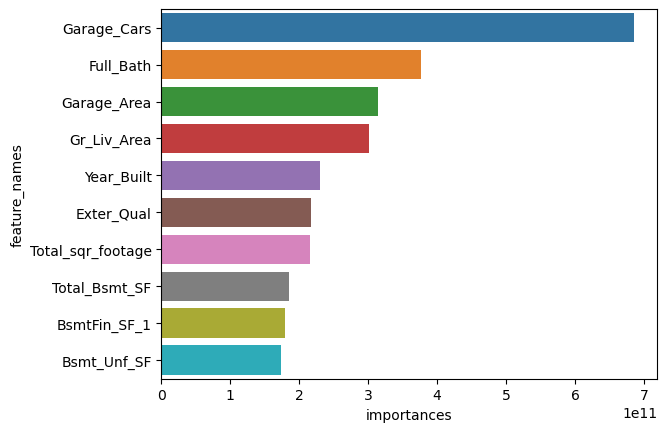

In [14]:
# 特徴量重要度の平均を算出して表を出力
display(feature_importance_df.groupby("feature_names").mean().sort_values("importances", ascending=False).head(10))
# 特徴量重要度を棒グラフで可視化
sns.barplot(x="importances", y="feature_names", 
            data=feature_importance_df.groupby("feature_names").mean().sort_values("importances", ascending=False)[:10].reset_index()
           )

In [15]:
# 提出ファイルを出力
submission.to_csv("fourth_submit.csv", index=False, header = False)

#### 参考サイト
https://qiita.com/ku_a_i/items/74241c84cda8c7327277